In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import cv2
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('../input/gtsrb-german-traffic-sign/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 In 'Train' folder directories are created by class numbers based.
 Train/class_num/class_num_images

<BarContainer object of 43 artists>

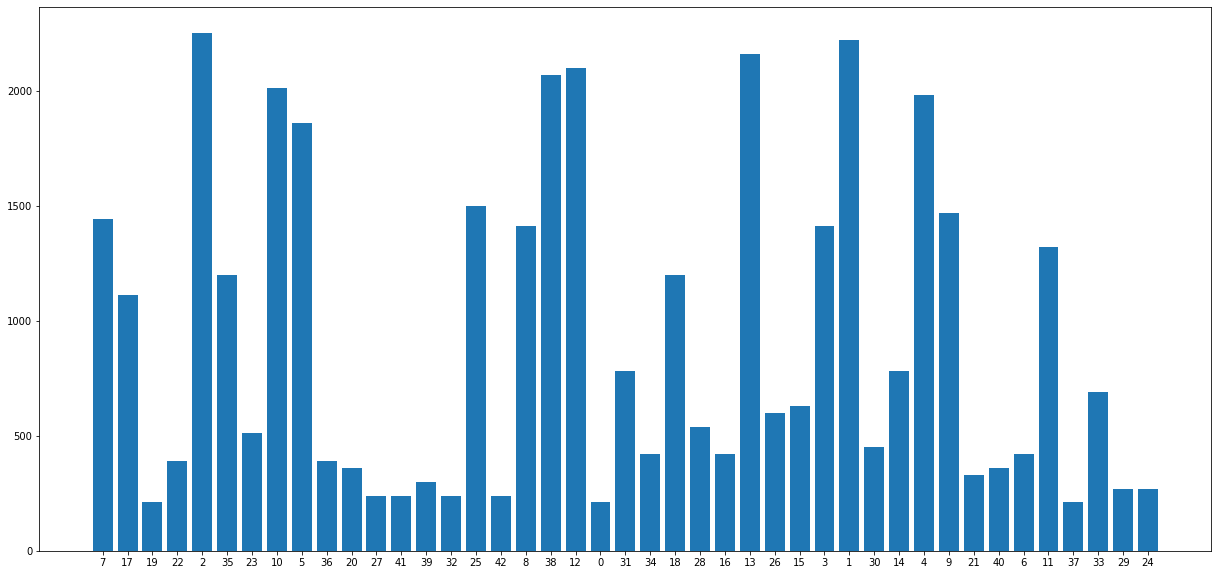

In [2]:
# let's see how many images are there per classes
folders = os.listdir(train_path)
#class_num:no.of samples
samples_dict = {} 

for folder in folders:
    images_in_folder = os.listdir(train_path + '/' + folder)
    samples_dict[folder] = len(images_in_folder)
    
plt.figure(figsize=(21,10))  
plt.bar(*zip(*samples_dict.items()))

In [3]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


2022-12-30 09:05:38.787811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 09:05:38.910717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 09:05:38.911513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


**Processing the training data**

In [4]:

    image_data = []
    image_labels = []
    class_num = len(os.listdir(train_path))
    for i in range(class_num):
        path = train_path +'/'+ str(i)
        images = os.listdir(path)

        for img in images:
            try:
                    
                #print(path+'/'+img)
                    image = cv2.imread(path + '/' + img)
                    image_fromarray = Image.fromarray(image, 'RGB')
                    resize_image = image_fromarray.resize((30, 30))
                    image_data.append(np.array(resize_image))
                    image_labels.append(i)
            except:
                print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)
X_train = X_train/255 
X_val = X_val/255

y_train = to_categorical(y_train, class_num)
y_val = to_categorical(y_val, class_num)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 30, 30, 3)
X_valid.shape (7842, 30, 30, 3)
y_train.shape (31367, 43)
y_valid.shape (7842, 43)


**Create the model**

In [6]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras_tuner.engine.hyperparameters import HyperParameters
hp = HyperParameters()

class Model(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential([
        tfl.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=8, max_value=32, step=8), 
            kernel_size=hp.Choice('conv_1_kernel', values = [3,5]), 
            activation='relu',
            padding='same',
            input_shape=(X_train.shape[1:])),
        tfl.MaxPool2D(pool_size=hp.Choice('conv_1_pool', values = [2,4])),
        
        tfl.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16), 
                   kernel_size=hp.Choice('conv_1_kernel', values = [3,5]), 
                   activation='relu',
                   padding='same'),
    #after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
    #after a Conv2D layer with data_format="channels_last", set axis=-1 in BatchNormalization.
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=hp.Float('layer1_drop',min_value=0.0, max_value=0.5)),
        
    
        tfl.Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=128, step=32), 
                   kernel_size=hp.Choice('conv_1_kernel', values = [3,5]), 
                   activation='relu',
                   padding='same'),
        tfl.MaxPool2D(pool_size=hp.Choice('conv_3_pool', values = [2,4])),
        tfl.Conv2D(filters=hp.Int('conv_4_filter', min_value=128, max_value=512, step=64), 
                   kernel_size=hp.Choice('conv_4_kernel', values = [3,5]), 
                   activation='relu',
                   padding='same'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=hp.Float('layer2_drop',min_value=0.0, max_value=0.5)),
    
        tfl.Flatten(),
        tfl.Dense(512,activation='relu'),
        tfl.BatchNormalization(),
        tfl.Dropout(rate=hp.Float('layer2_drop',min_value=0.0, max_value=0.5)),
    
        tfl.Dense(class_num, activation='softmax')
        
        ])
    
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        return model
    # The *args and **kwargs are the ones you passed from tuner.search()
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32]),
            **kwargs,
        )

tuner_random = kt.Hyperband(
    Model(),
    objective="val_accuracy")
# Using early stopping during training via passing in the tf.keras.callbacks.EarlyStopping callback. 
# This can be configured to stop your training as soon as the validation loss stops improving
# # Will stop training if the "val_loss" hasn't improved in 3 epochs.
tuner_random.search(X_train,y_train,epochs=30,validation_data=(X_val,y_val), callbacks=[tf.keras.callbacks.EarlyStopping("val_loss", patience=3)])

Trial 254 Complete [00h 00m 44s]
val_accuracy: 0.9924764037132263

Best val_accuracy So Far: 0.9968120455741882
Total elapsed time: 03h 52m 21s


In [7]:
# # Get the best models.
models = tuner_random.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(X_train.shape[1:]))
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 48)        6960      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 48)        192       
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0

In [8]:
# print hyper search space summary
# default search space size: is the no. of hyperparameters we are searching
tuner_random.search_space_summary()

Search space summary
Default search space size: 12
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 8, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_1_pool (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': None}
layer1_drop (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}
conv_3_pool (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4], 'ordered': True}
conv_4_filter (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': None}
conv_4_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'o

In [9]:
# Get the best hyperparameters.
best_hps = tuner_random.get_best_hyperparameters()
model = Model()
# Build the model with the best hp.
model = model.build(hp=best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))
history = model.fit(x=x_all, y=y_all, epochs=15)

Epoch 1/15
1226/1226 [==============================] - 8s 6ms/step - loss: 1.3297 - accuracy: 0.6301
Epoch 2/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.1450 - accuracy: 0.9542
Epoch 3/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.1026 - accuracy: 0.9680
Epoch 4/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.0735 - accuracy: 0.9764
Epoch 5/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.0636 - accuracy: 0.9801
Epoch 6/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.0613 - accuracy: 0.9814
Epoch 7/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.0459 - accuracy: 0.9852
Epoch 8/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.0383 - accuracy: 0.9882
Epoch 9/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.0396 - accuracy: 0.9872
Epoch 10/15
1226/1226 [==============================] - 7s 6ms/step - loss: 0.034

In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

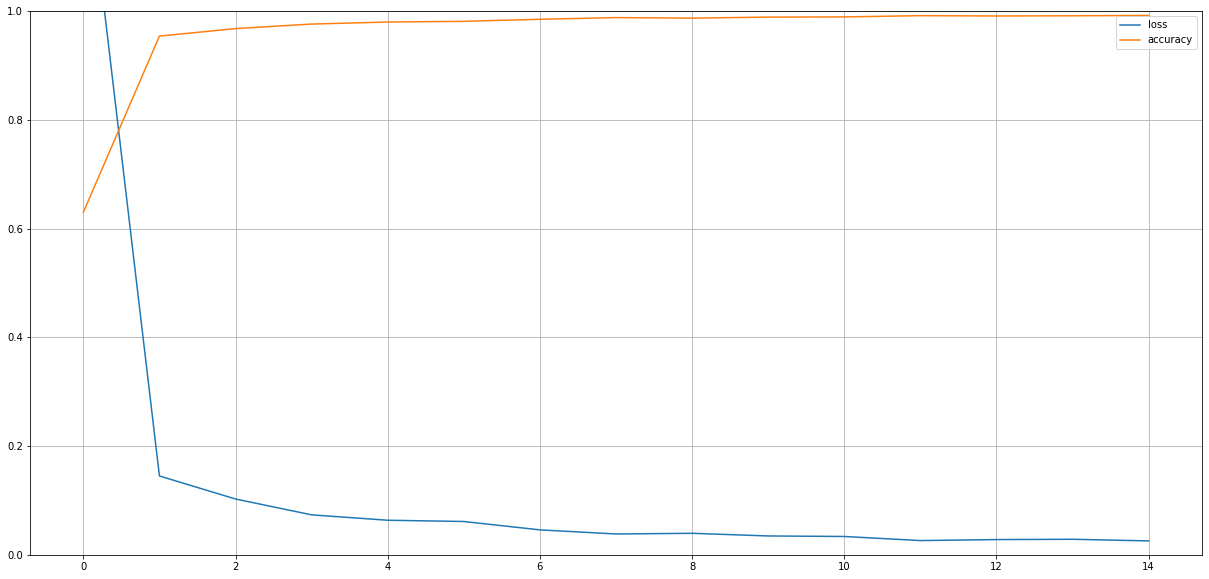

In [11]:
pd.DataFrame(history.history).plot(figsize=(21, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [12]:
from sklearn.metrics import accuracy_score
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test), axis=1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  97.07838479809976


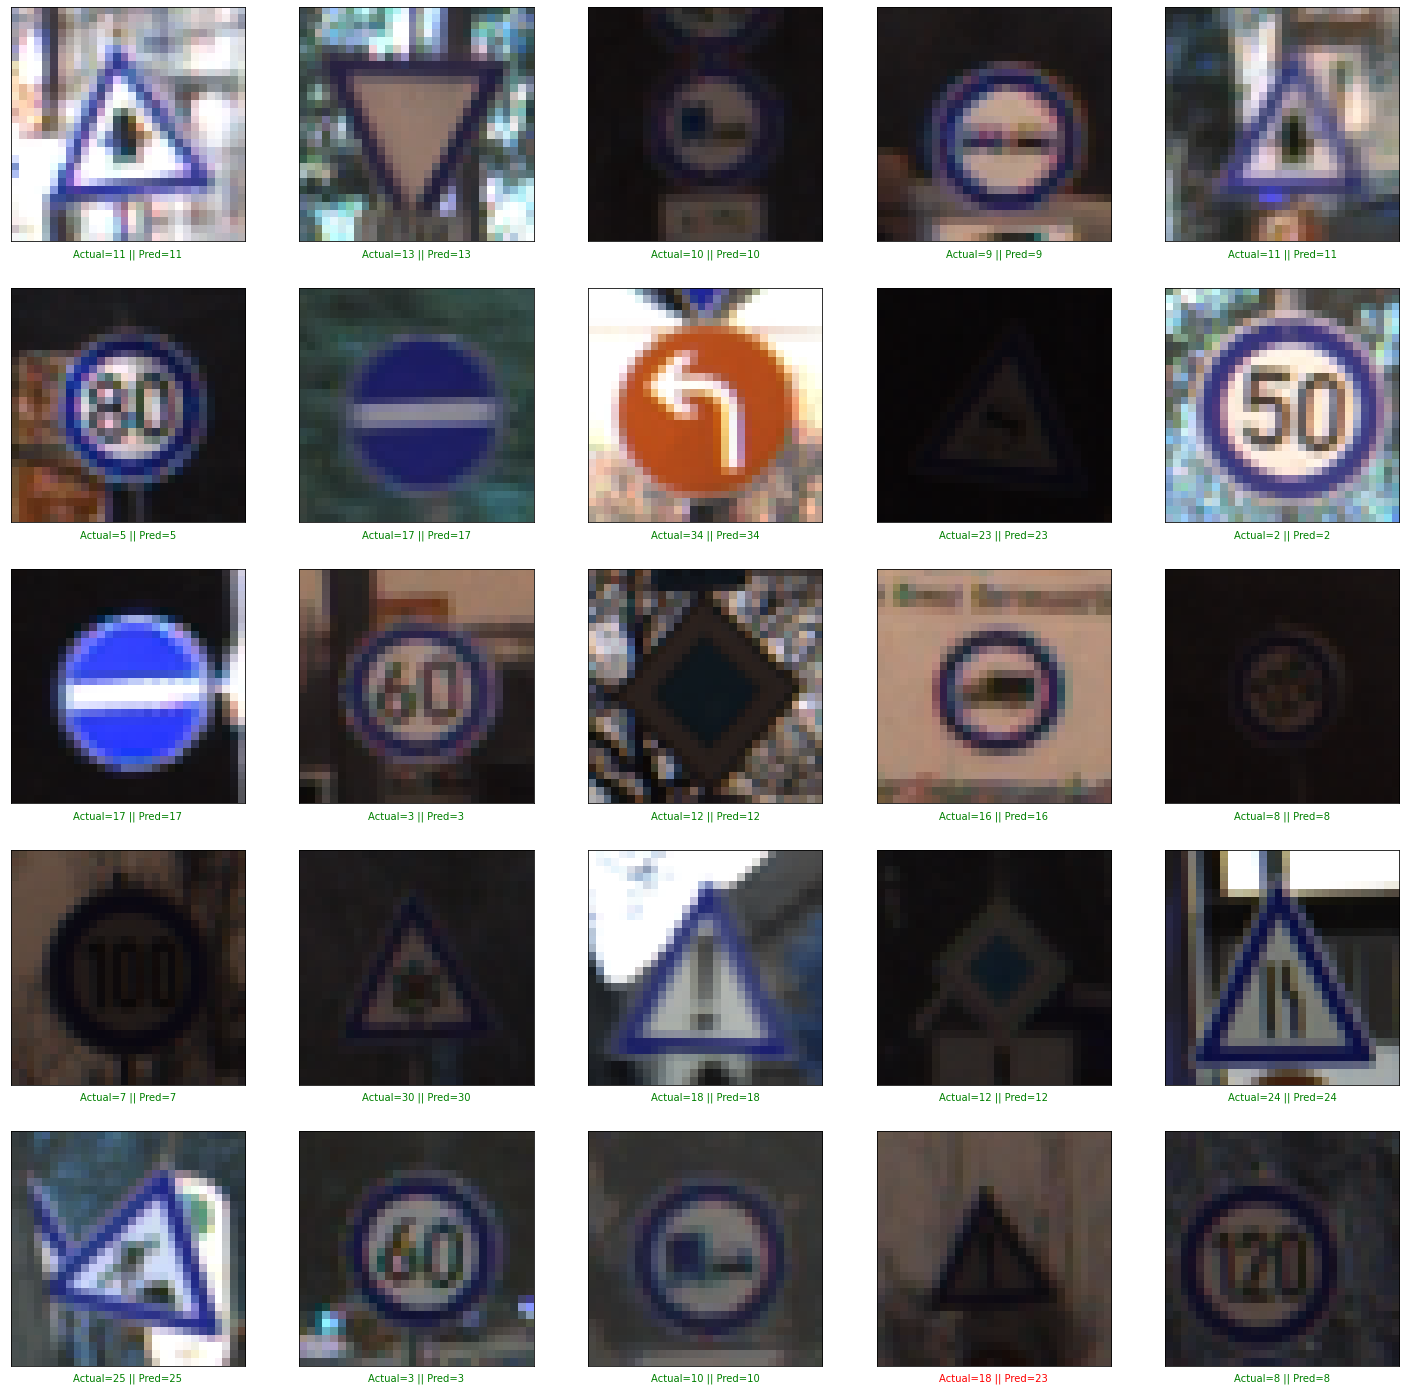

In [13]:
plt.figure(figsize = (25, 25))

start_index = 25
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()